# Eda

## Dependencias

In [43]:
# data wrangling
import pandas as pd
import numpy as np
import unicodedata
import re
import datetime

# Visualizacion
import seaborn as sb
import matplotlib.pyplot as plt
from plotly.offline import plot,iplot
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS

# Display options
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 35)

In [7]:
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"columna",0:"total"}) 
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

In [8]:
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    text=str(text)
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("utf-8"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().strip().lstrip().split())
    return cleaned_text if cleaned_text!="nan" else np.nan

## Lectura de datos

In [11]:
#df=pd.read_csv('../data/processed/df_data_quality',error_bad_lines=False,low_memory=False)
df=pd.read_csv('../data/processed/df_data_quality',error_bad_lines=False,low_memory=False,parse_dates=['d_datetime','d_dateposted'])
df.head(3)

,d_datetime,t_city,v_state,v_country,v_shape,c_duration(seconds),t_duration(hours/min),t_comments,d_dateposted,c_latitude,c_longitude
0,1949-10-10,san marcos,tx,us,cylinder,2700.0,45 minutes,this event took place in early fall around 194...,2004-04-27,29.883056,-97.941111
1,1949-10-10,lackland afb,tx,NaN,light,7200.0,1 2 hrs,1949 lackland afb 44 tx lights racing across t...,2005-12-16,29.384210,-98.581082
2,1955-10-10,chester uk england,NaN,gb,circle,20.0,20 seconds,green orange circular disc over chester 44 eng...,2008-01-21,53.200000,-2.916667


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   d_datetime             80332 non-null  datetime64[ns]
 1   t_city                 80329 non-null  object        
 2   v_state                74535 non-null  object        
 3   v_country              70662 non-null  object        
 4   v_shape                78400 non-null  object        
 5   c_duration(seconds)    80329 non-null  float64       
 6   t_duration(hours/min)  80332 non-null  object        
 7   t_comments             80316 non-null  object        
 8   d_dateposted           80332 non-null  datetime64[ns]
 9   c_latitude             80331 non-null  float64       
 10  c_longitude            80332 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(6)
memory usage: 6.7+ MB


## Formas mas comunes de los avistamientos

In [16]:
# Obtener el recuento de valores usando value_counts()
value_counts_result = df.v_shape.value_counts()

# Crear la gráfica de barras estética con Plotly
fig = px.bar(x=value_counts_result.index, y=value_counts_result.values, labels={'x': 'Formas', 'y': 'Frecuencia'},
             title='Gráfica de formas mas comunes en los avistamientos', text=value_counts_result.values)

# Personalizar el diseño de la gráfica
fig.update_traces(marker_color='rgb(55, 83, 109)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7, textposition='outside')

# Personalizar el diseño del diseño de la gráfica
fig.update_layout(title_text='Gráfica de formas mas comunes en los avistamientos',
                  xaxis_title='Formas',
                  yaxis_title='Frecuencia',
                  xaxis_tickangle=-45,
                  font=dict(family='Arial', size=12, color='black'),
                  plot_bgcolor='rgba(0,0,0,0)')

# Mostrar la gráfica
fig.show()

In [17]:
# Podemos observar que gran parte de los reportes afirman haber visto ovnis en forma de luces.
# Ademas, avistamientos de formas triangulares y circulares tambien predominan en los registros.

## ¿Cuanto duran los avistamientos?

In [29]:
# Calcular los deciles que deseamos mostrar
deciles = [i / 10 for i in range(1, 10)]

# Ejecutar la operación describe()
df_times = df['c_duration(seconds)'].describe(percentiles=deciles)

# Formatear los resultados como números flotantes
df_times = df_times.apply(lambda x: f'{x:.2f}' if isinstance(x, float) else x)

# Mostrar los resultados
df_times=df_times[4:13]
df_times

10%       5.00
20%      20.00
30%      60.00
40%     120.00
50%     180.00
60%     300.00
70%     600.00
80%     900.00
90%    1800.00
Name: c_duration(seconds), dtype: object

In [40]:
# Crear la gráfica de percentiles con Plotly
fig = go.Figure()

# Barras para los percentiles
fig.add_trace(go.Bar(x=df_times.index, y=df_times.values, name='Percentiles', marker_color='blue'))

fig.update_traces(marker_color='rgb(55, 83, 109)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7, textposition='outside')

# Personalizar la gráfica
fig.update_layout(title='Distribucion de los tiempos de avistamiento',
                  xaxis=dict(title='Deciles'),
                  yaxis=dict(title='Tiempo (segundos)'),
                  font=dict(family='Arial', size=12, color='black'),
                  plot_bgcolor='rgba(0,0,0,0)')

# Mostrar la gráfica
fig.show()

## ¿Que palabra es la mas comun en la descripcion de los avistamientos?

In [41]:
df.head(1)

,d_datetime,t_city,v_state,v_country,v_shape,c_duration(seconds),t_duration(hours/min),t_comments,d_dateposted,c_latitude,c_longitude
0,1949-10-10,san marcos,tx,us,cylinder,2700.0,45 minutes,this event took place in early fall around 194...,2004-04-27,29.883056,-97.941111


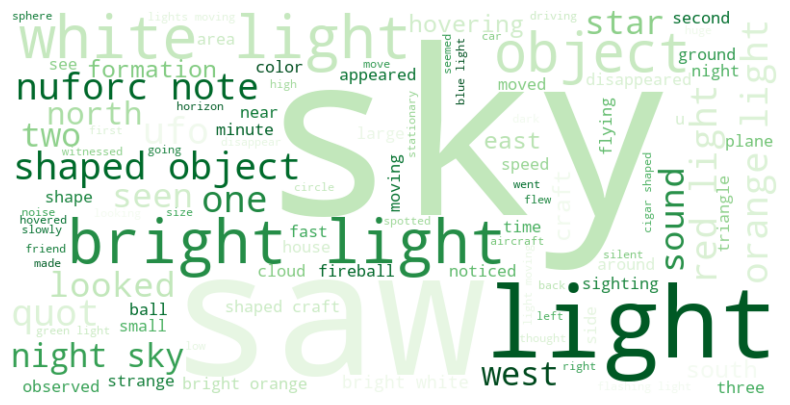

In [51]:
df['t_comments'] = df['t_comments'].astype(str)
# Concatenar todas las descripciones en un solo texto
all_comments = ' '.join(df['t_comments'])

# Definir las palabras que queremos excluir de la nube de palabras
stopwords = set(STOPWORDS)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, max_words=100,
                      colormap='Greens', contour_width=1, contour_color='darkgreen').generate(all_comments)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## ¿Cuanto tiempo pasa entre la ocurrencia del avistamiento y la publicacion del reporte?

In [52]:
df.head(1)

,d_datetime,t_city,v_state,v_country,v_shape,c_duration(seconds),t_duration(hours/min),t_comments,d_dateposted,c_latitude,c_longitude
0,1949-10-10,san marcos,tx,us,cylinder,2700.0,45 minutes,this event took place in early fall around 194...,2004-04-27,29.883056,-97.941111


In [54]:
# creamos la variable de interes, la llamaremos: diff_rep
df['diff_rep'] = (df['d_dateposted'].dt.year - df['d_datetime'].dt.year) * 12 + df['d_dateposted'].dt.month - df['d_datetime'].dt.month
df.head(3)

,d_datetime,t_city,v_state,v_country,v_shape,c_duration(seconds),t_duration(hours/min),t_comments,d_dateposted,c_latitude,c_longitude,diff_rep
0,1949-10-10,san marcos,tx,us,cylinder,2700.0,45 minutes,this event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,654
1,1949-10-10,lackland afb,tx,NaN,light,7200.0,1 2 hrs,1949 lackland afb 44 tx lights racing across t...,2005-12-16,29.384210,-98.581082,674
2,1955-10-10,chester uk england,NaN,gb,circle,20.0,20 seconds,green orange circular disc over chester 44 eng...,2008-01-21,53.200000,-2.916667,627


In [55]:
# Calcular los deciles que deseamos mostrar
deciles = [i / 10 for i in range(1, 10)]

# Ejecutar la operación describe()
df_rep = df['diff_rep'].describe(percentiles=deciles)

# Formatear los resultados como números flotantes
df_rep = df_rep.apply(lambda x: f'{x:.2f}' if isinstance(x, float) else x)

# Mostrar los resultados
df_rep=df_rep[4:13]
df_rep

10%      0.00
20%      0.00
30%      0.00
40%      1.00
50%      1.00
60%      1.00
70%      2.00
80%     13.80
90%    119.00
Name: diff_rep, dtype: object

In [57]:
# Crear la gráfica de percentiles con Plotly
fig = go.Figure()

# Barras para los percentiles
fig.add_trace(go.Bar(x=df_rep.index, y=df_rep.values, name='Percentiles', marker_color='blue'))

fig.update_traces(marker_color='rgb(55, 83, 109)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7, textposition='outside')

# Personalizar la gráfica
fig.update_layout(title='Distribucion de los tiempos ocurridos entre la ocurrencia del avistamiento y la publicacion del reporte',
                  xaxis=dict(title='Deciles'),
                  yaxis=dict(title='Tiempo (meses)'),
                  font=dict(family='Arial', size=12, color='black'),
                  plot_bgcolor='rgba(0,0,0,0)')

# Mostrar la gráfica
fig.show()

## Ubicaciones de los avistamientos

In [60]:
df.head(1)

,d_datetime,t_city,v_state,v_country,v_shape,c_duration(seconds),t_duration(hours/min),t_comments,d_dateposted,c_latitude,c_longitude,diff_rep
0,1949-10-10,san marcos,tx,us,cylinder,2700.0,45 minutes,this event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,654


In [62]:
df_=df.copy()

In [63]:
df_.dropna(inplace=True)

In [65]:
'''import folium
# Crear el mapa
m = folium.Map(location=[df_['c_latitude'].mean(), df_['c_longitude'].mean()], zoom_start=5)

# Agregar burbujas de densidad al mapa
for i, row in df_.iterrows():
    folium.CircleMarker(location=[row['c_latitude'], row['c_longitude']],
                        radius=10,
                        color='blue',
                        fill=True,
                        fill_color='blue').add_to(m)

# Mostrar el mapa
m'''

"import folium\n# Crear el mapa\nm = folium.Map(location=[df_['c_latitude'].mean(), df_['c_longitude'].mean()], zoom_start=5)\n\n# Agregar burbujas de densidad al mapa\nfor i, row in df_.iterrows():\n    folium.CircleMarker(location=[row['c_latitude'], row['c_longitude']],\n                        radius=10,\n                        color='blue',\n                        fill=True,\n                        fill_color='blue').add_to(m)\n\n# Mostrar el mapa\nm"

## Exportamos el dataset

In [66]:
df.to_csv('../data/processed/df_eda', index=False)